# Using text factorization in a sentiment analysis model

data downloaded from https://oreil.ly/tfjoP

In [1]:
import pandas as pd

df = pd.read_csv('../Data/reviews.csv', encoding="ISO-8859-1")
df = df.sample(frac=1, random_state=0)
df.head()

,Text,Sentiment
11841,Al Pacino was once an actor capable of making ...,0
19602,After Chaplin made one of his best films: Doug...,0
45519,This movie is sort of a Carrie meets Heavy Met...,1
25747,I have fond memories of watching this visually...,1
42642,"In the '70s, Charlton Heston starred in sci-fi...",1


In [2]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  Al Pacino was once an actor capable of making ...   
1          24884  24884  This movie is sort of a Carrie meets Heavy Met...   

                
          freq  
Sentiment       
0            1  
1            1

In [16]:
# from tensorflow.keras.models import Sequential, Input
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.layers import TextVectorization, InputLayer
from tensorflow.keras.layers import Dense, Flatten, Embedding
import tensorflow as tf

x_tf = tf.constant(df['Text'].fillna('').astype(str).tolist(), dtype=tf.string)
x_tf = tf.reshape(x_tf, (-1, 1))                             # (N,1) tf.string
y_tf = tf.constant(df['Sentiment'].astype('float32').to_numpy(), dtype=tf.float32)

max_words, max_len = 20000, 500
tv = layers.TextVectorization(max_tokens=max_words,
                              output_sequence_length=max_len,
                              standardize='lower_and_strip_punctuation')
tv.adapt(x_tf) 

model = Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    tv,
    layers.Embedding(max_words, 32),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ds = tf.data.Dataset.from_tensor_slices((x_tf, y_tf)).batch(256).prefetch(tf.data.AUTOTUNE)
val_batches = int(0.5 * len(df) / 256)
val_ds = ds.take(val_batches)
train_ds = ds.skip(val_batches)
hist =model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=250)

Epoch 1/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5489 - loss: 0.6846 - val_accuracy: 0.7142 - val_loss: 0.6501
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7246 - loss: 0.5698 - val_accuracy: 0.8017 - val_loss: 0.4706
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8181 - loss: 0.4196 - val_accuracy: 0.8527 - val_loss: 0.3694
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8579 - loss: 0.3448 - val_accuracy: 0.8694 - val_loss: 0.3289
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8759 - loss: 0.3034 - val_accuracy: 0.8721 - val_loss: 0.3122
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8896 - loss: 0.2737 - val_accuracy: 0.8764 - val_loss: 0.3013
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9000 - loss: 0.2501 - val_accuracy: 0.8769 - val_loss: 0.2973
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9085 - loss: 0.2319 - val_accuracy: 0.8759 - v

[]

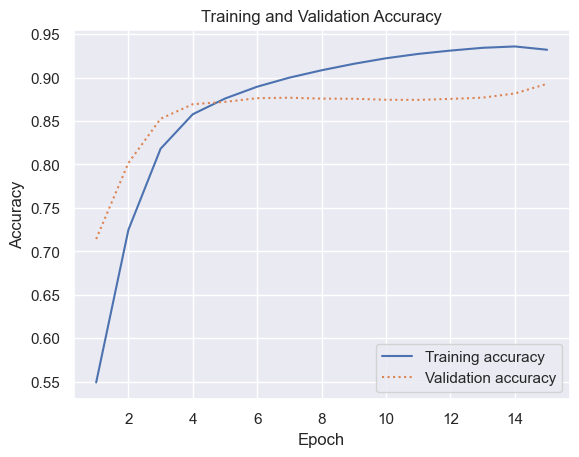

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Predict positive review

In [18]:
def predict_(text: str):
    x_new = tf.constant([text], dtype=tf.string)
    x_new = tf.reshape(x_new, (1, 1))
    prob = model.predict(x_new, verbose=0)[0, 0]
    label = "positive" if prob >= 0.5 else "negative"
    return prob, label

p, lbl = predict_("I absolutely loved this product, super fast shipping!")
print(p, lbl)

p, lbl = predict_("I absolutely hate this product, super late shipping!")
print(p, lbl)

p, lbl = predict_("The long lines and poor customer service really turned me off.")
print(p, lbl)

0.6544183 positive
0.52162147 positive
0.27279678 negative


Maybe more epochs could make this a little more accurate?